训练并导出LSTM模型

In [39]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as torch
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

import mylib

In [40]:
# device = mylib.choose_device()
device = torch.device("cpu")
print(device)
os.environ["KMP_DUPLICATE_LIB_OK"] = "1"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

cpu


In [41]:
df = pd.read_csv("../datasets/mfp/train_data.csv", dtype={'v': np.float32}, index_col=0, parse_dates=True)
print(type(df[['v']].iloc[0].values[0]))

<class 'numpy.float32'>


## 查看原始数据

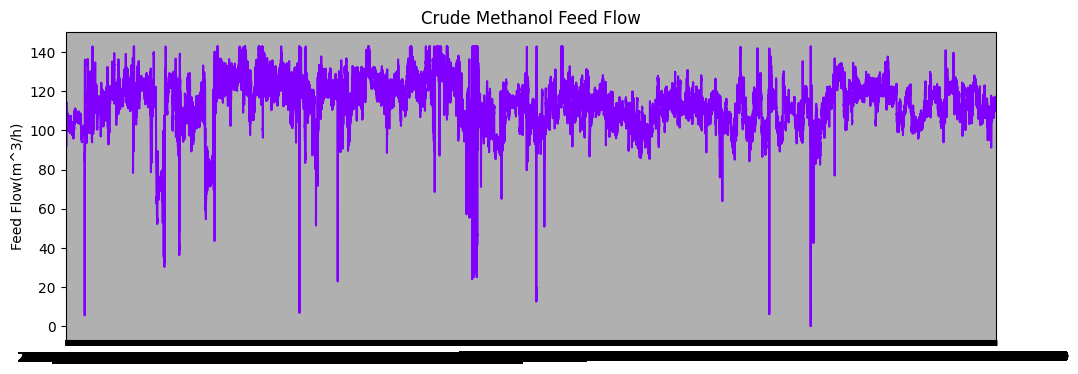

In [31]:
plt.figure(figsize=(12, 4))
plt.title('Crude Methanol Feed Flow')
plt.ylabel('Feed Flow(m^3/h)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['v'], color='#8000ff')
plt.show()

In [32]:
# 准备数据

In [33]:
train_df = pd.read_csv("../datasets/mfp/train_data.csv", dtype={'v': np.float32}, index_col='t', parse_dates=True)
train_set = train_df.values.astype(float)

In [ ]:
train_set


# 归一化处理

In [34]:
from torch.autograd import Variable

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


sc = MinMaxScaler()
training_data = sc.fit_transform(train_set)

seq_length = 1
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.tensor(np.array(x), dtype=torch.float32, device=device))
dataY = Variable(torch.tensor(np.array(y), dtype=torch.float32, device=device))

trainX = Variable(torch.tensor(np.array(x[0:train_size]), dtype=torch.float32, device=device))
trainY = Variable(torch.tensor(np.array(y[0:train_size]), dtype=torch.float32, device=device))

testX = Variable(torch.tensor(np.array(x[train_size:len(x)]), dtype=torch.float32, device=device))
testY = Variable(torch.tensor(np.array(y[train_size:len(y)]), dtype=torch.float32, device=device))

# 定义模型

In [35]:
from torch import nn


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

Instantiation, loss and optimizer

In [36]:
num_epochs = 4000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device=device)

criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: nan
Epoch: 100, loss: nan
Epoch: 200, loss: nan
Epoch: 300, loss: nan
Epoch: 400, loss: nan
Epoch: 500, loss: nan
Epoch: 600, loss: nan
Epoch: 700, loss: nan
Epoch: 800, loss: nan
Epoch: 900, loss: nan
Epoch: 1000, loss: nan
Epoch: 1100, loss: nan
Epoch: 1200, loss: nan
Epoch: 1300, loss: nan
Epoch: 1400, loss: nan
Epoch: 1500, loss: nan
Epoch: 1600, loss: nan
Epoch: 1700, loss: nan
Epoch: 1800, loss: nan
Epoch: 1900, loss: nan
Epoch: 2000, loss: nan
Epoch: 2100, loss: nan
Epoch: 2200, loss: nan
Epoch: 2300, loss: nan
Epoch: 2400, loss: nan
Epoch: 2500, loss: nan
Epoch: 2600, loss: nan
Epoch: 2700, loss: nan
Epoch: 2800, loss: nan
Epoch: 2900, loss: nan
Epoch: 3000, loss: nan
Epoch: 3100, loss: nan
Epoch: 3200, loss: nan
Epoch: 3300, loss: nan
Epoch: 3400, loss: nan
Epoch: 3500, loss: nan
Epoch: 3600, loss: nan
Epoch: 3700, loss: nan
Epoch: 3800, loss: nan
Epoch: 3900, loss: nan


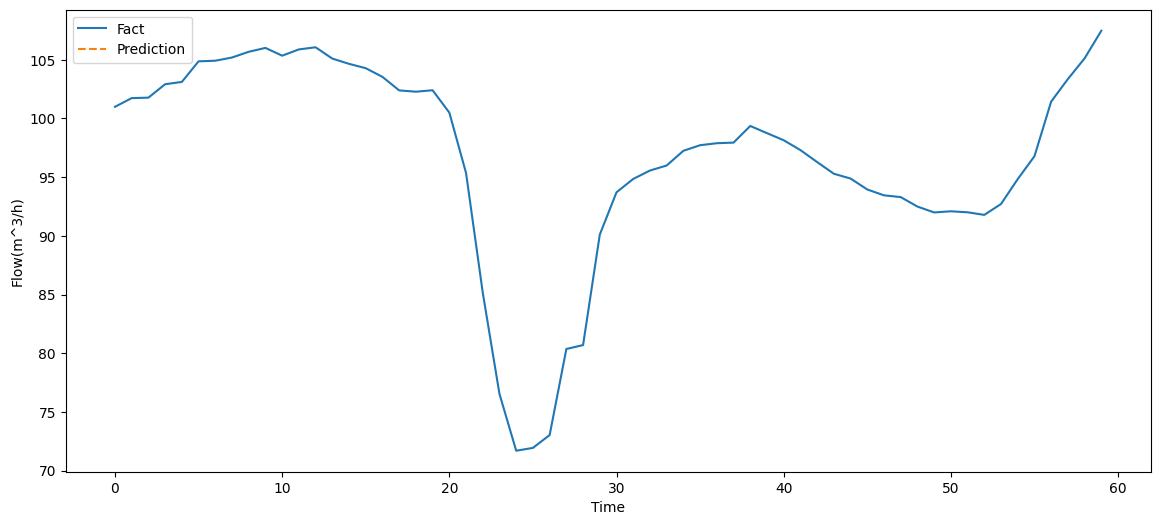

In [37]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Flow(m^3/h)')
ax.plot(dataY_plot[:60], label='Fact')
ax.plot(data_predict[:60], linestyle='--', label='Prediction')
plt.legend()
plt.show()

训练

In [38]:
torch.save(lstm.state_dict(), "./output/model/flow_speed_rnn.pt")